# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Cats-and-Dogs-(3):-Ajuste-fino-da-rede-pré-treinada" data-toc-modified-id="Cats-and-Dogs-(3):-Ajuste-fino-da-rede-pré-treinada-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cats and Dogs (3): Ajuste fino da rede pré-treinada</a></div><div class="lev2 toc-item"><a href="#Dataset" data-toc-modified-id="Dataset-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset</a></div><div class="lev2 toc-item"><a href="#Procedimento-de-treino" data-toc-modified-id="Procedimento-de-treino-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Procedimento de treino</a></div><div class="lev2 toc-item"><a href="#A-rede-VGG" data-toc-modified-id="A-rede-VGG-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>A rede VGG</a></div><div class="lev2 toc-item"><a href="#Construção-da-rede-neural" data-toc-modified-id="Construção-da-rede-neural-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Construção da rede neural</a></div><div class="lev2 toc-item"><a href="#Treinamento" data-toc-modified-id="Treinamento-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Treinamento</a></div><div class="lev2 toc-item"><a href="#Avaliação" data-toc-modified-id="Avaliação-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Avaliação</a></div><div class="lev2 toc-item"><a href="#Aprendizados-com-este-notebook" data-toc-modified-id="Aprendizados-com-este-notebook-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Aprendizados com este notebook</a></div>

# Cats and Dogs (3): Ajuste fino da rede pré-treinada

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Esta é a última parte de três do experimento de *transfer learning*.

Neste experimento, a rede VGG é montada completa, com a parte convolucional e a parte da rede densa treinada no notebook anterior. As camadas finais da parte convolucional são liberadas para o treinamento, juntamente com a rede densa obtida no notebook anterior (*fine tuning*). Os pesos das camadas iniciais da VGG são mantidos constantes.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import os
import sys
import numpy as np
import numpy.random as nr

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD, RMSprop

print('Keras ', keras.__version__)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

import os
os.makedirs('../../models', exist_ok=True)

Using TensorFlow backend.


Keras  2.0.4


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')
image_format = K.image_data_format()

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(image_format))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


## Dataset

https://www.kaggle.com/c/dogs-vs-cats/data


In [3]:
train_data_dir = '../../datasets/CatsDogs/train'
valid_data_dir = '../../datasets/CatsDogs/validation'
nb_train_samples = 2000
nb_valid_samples = 800

batch_size = 40
img_width, img_height = 150, 150

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

valid_generator = test_datagen.flow_from_directory(
        valid_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Procedimento de treino

In [4]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, train_generator, validation_generator, 
                  train_steps=10, valid_steps=10, opt='rmsprop', loss='mse', metrics=[], 
                  nepochs=50, patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    # initialize the optimizer and model
    print("[INFO] compiling model...")
    model.compile(loss=loss, optimizer=opt, metrics=metrics)    
    
    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
        model.fit_generator(train_generator, steps_per_epoch=train_steps,
                            validation_data=validation_generator, validation_steps=valid_steps,
                            epochs=nepochs, verbose=vv, callbacks=[cb])
    except KeyboardInterrupt:
        pass

    model, histo = load_model_and_history(model_name)
    return model, cb


def test_network(model_name, validation_generator, nb_validation_samples):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate_generator(validation_generator, nb_validation_samples)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## A rede VGG

[![VGG Network Layers](https://blog.keras.io/img/imgclf/vgg16_modified.png)]()

## Construção da rede neural

In [5]:
model_name = '../../models/cats_dogs_vgg_finetune'   # modelo da rede atual

def build_net(img_width, img_height):
    from keras.applications.vgg16 import VGG16
    
    print("[INFO] creating model...")
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
    
    # build a classifier model and put on top of the convolutional model
    x = Flatten()(vgg.output)
    x = Dense(256, activation='relu', name='d1')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid', name='d2')(x)
    
    model = Model(inputs=vgg.input, outputs=x)

    #     print('Model layers:')
    #     for i, layer in enumerate(model.layers):
    #         print('    {:2d} {:15s} {}'.format(i, layer.name, layer))
    
    # modelo da rede densa treinada no notebook anterior
    top_model_name = '../../models/cats_dogs_vgg.model'
    # Carrego os pesos treinados anteriormente
    w1, b1, w2, b2 = load_model(top_model_name).get_weights()    
    # Coloco nas camadas densas finais da rede
    model.layers[20].set_weights([w1, b1])
    model.layers[22].set_weights([w2, b2])
    
    # Torno não-treináveis as primeiras 15 camadas
    # da rede (os pesos não serão alterados)
    for layer in model.layers[:15]:
        layer.trainable = False
        
    return model

model = build_net(img_width, img_height)
model.summary()


[INFO] creating model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)   

## Treinamento

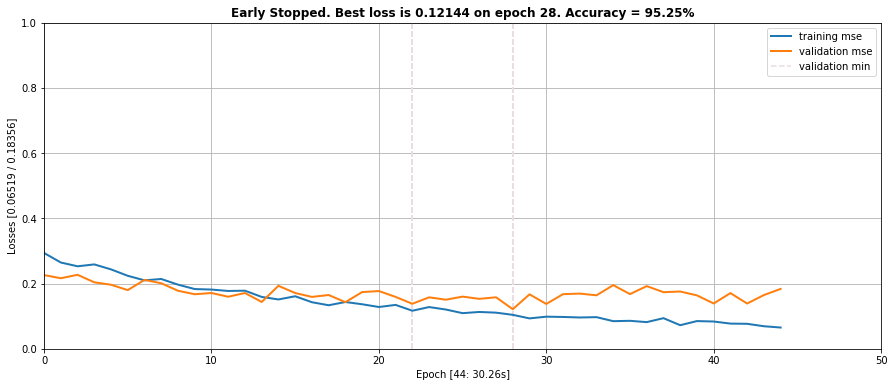

In [6]:
fit_params = {
    'train_steps':     nb_train_samples / batch_size,
    'valid_steps':     nb_valid_samples / batch_size,
    'opt':             SGD(lr=0.0001, momentum=0.9, nesterov=True), 
    'loss':            'binary_crossentropy', 
    'metrics':         ['accuracy'],
    'nepochs':         50, 
    'patience':        15,
    'ploss':           1.0,
    'reset':           False,
}

train_network(model, model_name, train_generator, valid_generator, **fit_params);

## Avaliação

In [7]:
test_network(model_name, valid_generator, nb_valid_samples / batch_size)

Model from epoch 28
[INFO] evaluating in the test data set ...

[INFO] accuracy on the test data set: 93.38% [0.16835]


## Aprendizados com este notebook

